# Hierarchical Linear Regression (Radon Contamination dataset)

In this example we want to revisit the classical example of hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how easy is to port the [`PyMC`](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [`Bambi`](https://bambinos.github.io/bambi/main/index.html) using the more concise formula specification for the models.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "svg"

## Read Data

Let us load the data into a pandas dataframe.

In [3]:
# Get radon data
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
radon_df = pd.read_csv(path)

# Get city data
city_df = pd.read_csv(pm.get_data("cty.dat"))

## Preprocess Data

Let us start by preprocessing the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html). We want to keep the same notation as in the article.

In [4]:
# Strip spaces from column names
radon_df.columns = radon_df.columns.map(str.strip)

# Filter so we keep observations for state "MN" only
df = radon_df[radon_df.state == "MN"].copy()
city_mn_df = city_df[city_df.st == "MN"].copy()

# Compute fips
df["fips"] = 1_000 * df.stfips + df.cntyfips
city_mn_df["fips"] = 1_000 * city_mn_df.stfips + city_mn_df.ctfips

# Merge data
df = df.merge(city_mn_df[["fips", "Uppm"]], on="fips")
df = df.drop_duplicates(subset="idnum")

# Clean county names
df.county = df.county.map(str.strip)

# Compute log(radon + 0.1)
df["log_radon"] = np.log(df["activity"] + 0.1)

# Compute log of Uranium
df["log_u"] = np.log(df["Uppm"])

# Let's map floor. 0 -> Basement and 1 -> Floor
df["floor"] = df["floor"].map({0: "Basement", 1: "Floor"})

# Reset index
df = df.reset_index(drop=True)

## EDA

Let us do some exploratory data analysis. To get a glimpse of the data we are going to use. First Let us see global `log_radon` distribution.

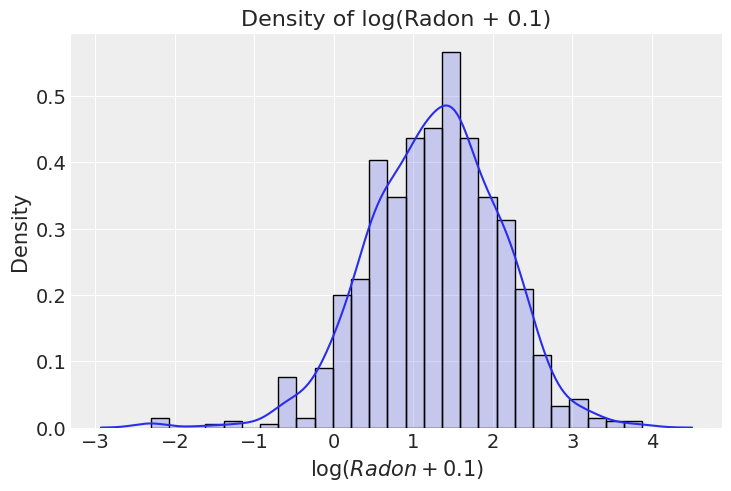

In [5]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon",  alpha=0.2, stat="density", data=df, ax=ax)
sns.kdeplot(x="log_radon", data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log(Radon + 0.1)$", ylabel="Density");

Let us now se the split per `floor`:

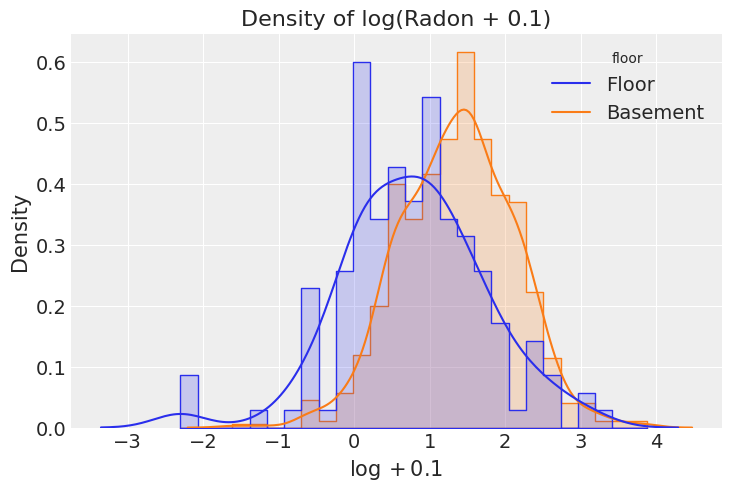

In [6]:
fig, ax = plt.subplots()
sns.histplot(
    x="log_radon", hue="floor", alpha=0.2, stat="density", element="step", 
    common_norm=False, data=df, ax=ax
)
sns.kdeplot(x="log_radon", hue="floor", common_norm=False, data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log + 0.1$", ylabel="Density");

Next, let us count the number of counties.

In [7]:
print(f"Number of counties: {df['county'].unique().size}")

Number of counties: 85


Let us dig deeper into the distribution of radon per county and floor level.

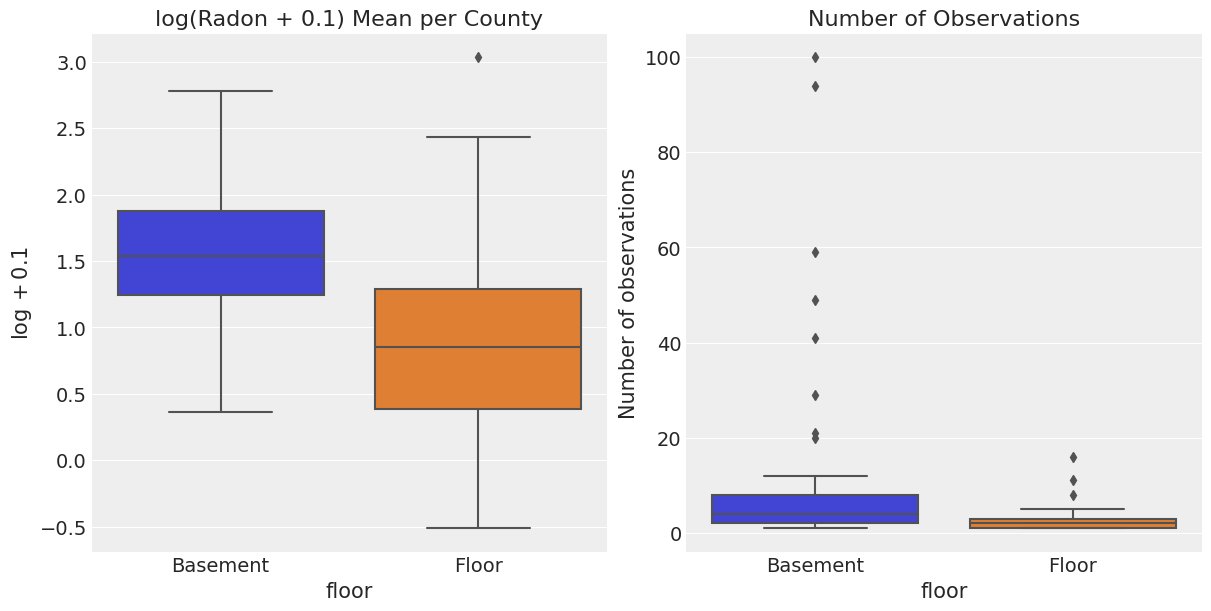

In [8]:
log_radon_county_agg  = (
    df 
    .groupby(["county", "floor"], as_index=False)
    .agg(
        log_radon_mean=("log_radon", "mean"),
        n_obs=("log_radon", "count")
    )
)

fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout="constrained")
sns.boxplot(x="floor", y="log_radon_mean", data=log_radon_county_agg, ax=ax[0])
ax[0].set(title="log(Radon + 0.1) Mean per County", ylabel="$\log + 0.1$");
sns.boxplot(x="floor", y="n_obs", data=log_radon_county_agg, ax=ax[1])
ax[1].set(title="Number of Observations", xlabel="floor", ylabel="Number of observations");

We see that there are some counties with a lot of basement observations. This can create some bias when computing simple statistics to compare across counties. Moreover, not all `county` and `floor` combinations are present in the dataset. For example:

In [9]:
assert df.query("county == 'YELLOW MEDICINE' and floor == 'Floor'").empty

## Models: Conventional Approaches

### Complete Pooling

#### Model

For this first model we only consider the predictor `floor`, which represents the floor level. The following equation describes the linear model that we are going to build with Bambi

$$
y_{i} = \beta_{j[i]} + \varepsilon_i
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\beta_{j[i]} &= \text{Intercept for the Floor level } j \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$

Each $j$ indexes a different floor level. In this case, $j=1$ means Basement and $j=2$ means Floor.

#### Priors

##### Common effects

The only common effects in this model are the $\beta_{j[i]}$. We have

$$
\begin{array}{lr}
\beta_{j[i]} \sim \text{Normal}(0, \sigma_\beta) & \text{for all } j:1, 2
\end{array}
$$

where $\sigma_\beta$ is a positive constant that we set to 10. 

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

 where $\lambda$ is a positive constant that we set to 1. 

#### Notes

* The notation $j[i]$ means that the Floor level $j$ depends on the measurement $i$ we're looking at. This is because each measurement $i$ is tied to one, and only one Floor level.
* The coefficients $\beta_{i[j]}$ are going to represent the mean Radon level for the floor $j$-th floor.

##### Pooling

In this Radon example, the pooling refers to what we do with the different Counties when we compute estimates (i.e. this does not refer to pooling across floor levels for example). _Complete pooling_ means that all the measurements for all Counties are pooled into a single estimate ("treat all counties the same"), conditional on the floor level (because we are using floor as a covariate/predictor).

Let us now write the Bambi model:

In [10]:
pooled_priors = {
    "floor": bmb.Prior(name="Normal", mu=0, sigma=10),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

pooled_model = bmb.Model(
    formula="log_radon ~ 0 + floor",
    data=df,
    priors=pooled_priors,
    family="gaussian",
    link="identity"
)

pooled_model

Formula: log_radon ~ 0 + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

Here are some remarks:

- The `0` at the beginning makes sure we remove the intercept, which allows the model to use one coefficient for each floor level.
- There's no need to talk about centered vs non-centered parametrisations here because that refers to group-specific (aka varying, aka random) effects. So far this model has only one common (aka fixed) effect which is the floor level.
- Also `autoscale` is not needed here because we're passing priors by hand


Let us now fit the model:

In [11]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


Let us see the graph representation of the model:

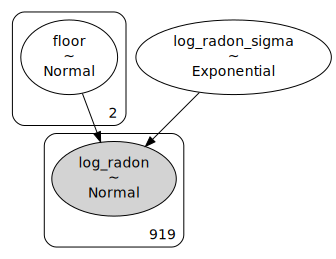

In [12]:
pooled_model.graph()

Now we can examine the posterior distribution of the model parameters:

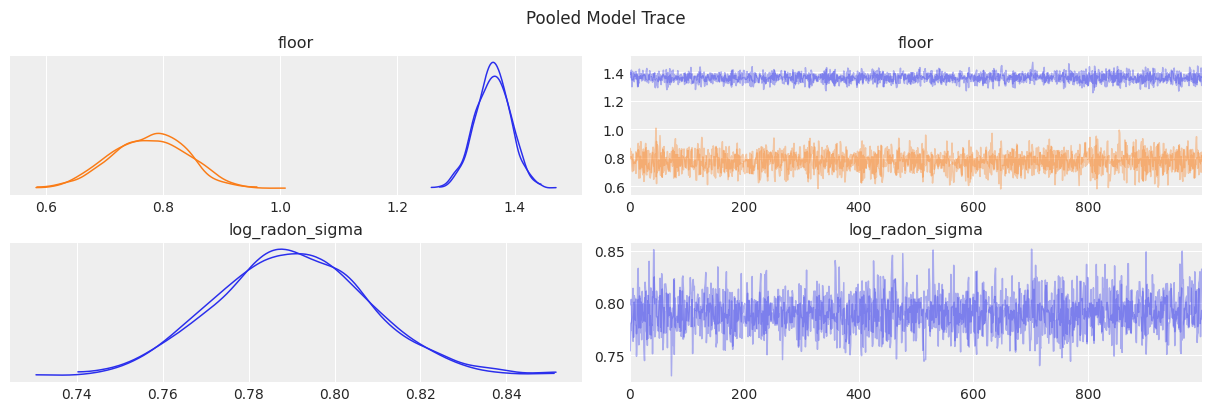

In [13]:
az.plot_trace(data=pooled_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Pooled Model Trace");

We can now see some summary statistics. 

In [14]:
pooled_summary = az.summary(data=pooled_results)
pooled_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
floor[Basement]  1.363  0.030   1.303    1.417      0.001    0.000    2548.0   
floor[Floor]     0.776  0.066   0.649    0.893      0.001    0.001    2610.0   
log_radon_sigma  0.790  0.018   0.757    0.822      0.000    0.000    2140.0   

                 ess_tail  r_hat  
floor[Basement]    1567.0    1.0  
floor[Floor]       1459.0    1.0  
log_radon_sigma    1507.0    1.0

From the posterior plot and the summary, we can see the mean radon level is considerably higher in the Basement than in the Floor level.

We can compare the mean of the posterior distribution of the `floor` terms to the sample mean:

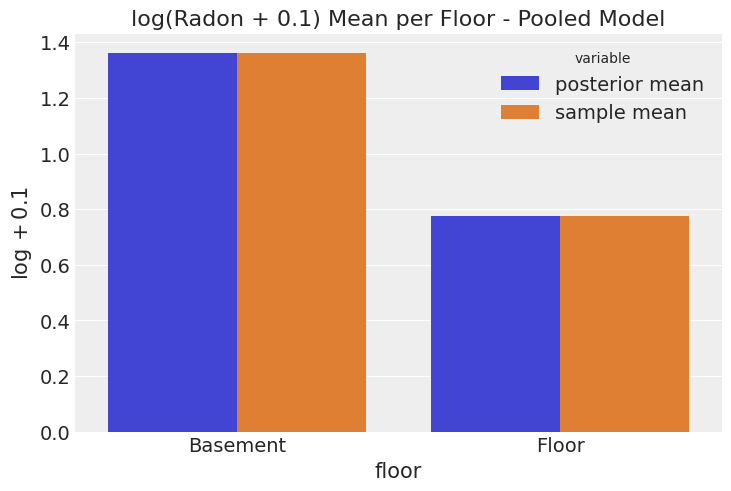

In [15]:
fig, ax = plt.subplots()

(
    pooled_summary["mean"]
    .iloc[:-1]
    .reset_index()
    .assign(floor = lambda x: x["index"].str.slice(6, -1).str.strip())
    .merge(
        right=df.groupby(["floor"])["log_radon"].mean(),
        left_on="floor",
        right_index=True
    )
    .rename(columns={
        "mean": "posterior mean",
        "log_radon": "sample mean"
    })
    .melt(
        id_vars="floor",
        value_vars=["posterior mean", "sample mean"]
    )
    .pipe((sns.barplot, "data"),
        x="floor",
        y="value",
        hue="variable",
        ax=ax
    )
)
ax.set(title="log(Radon + 0.1) Mean per Floor - Pooled Model", ylabel="$\log + 0.1$");

We see that estimation for the observations in either group is the group mean (plus the smoothing because of the prior).

If we transform the results back to the original measurement scale we have

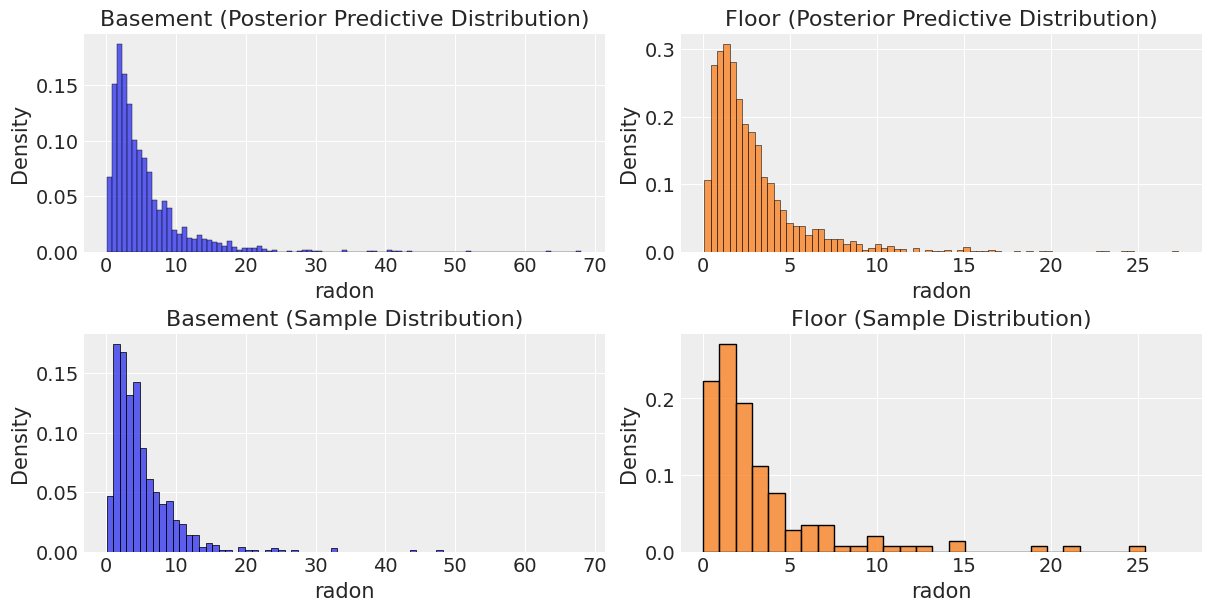

In [16]:
new_data = pd.DataFrame({"floor": ["Basement", "Floor"]})
pooled_model.predict(pooled_results, kind="pps", data=new_data)

pps = pooled_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

# Inverse transform
pps = np.exp(pps) - 0.1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), layout="constrained")
ax = ax.flatten()

sns.histplot(x=pps[0].flatten(), stat="density", color="C0", ax=ax[0])
ax[0].set(title="Basement (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density");
sns.histplot(x="activity", data=df.query("floor == 'Basement'"), stat="density", ax=ax[2])
ax[2].set(title="Basement (Sample Distribution)", xlim=ax[0].get_xlim(), xlabel="radon", ylabel="Density");

sns.histplot(x=pps[1].flatten(), stat="density", color="C1", ax=ax[1])
ax[1].set(title="Floor (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density");
sns.histplot(x="activity", data=df.query("floor == 'Floor'"), stat="density", color="C1", ax=ax[3])
ax[3].set(title="Floor (Sample Distribution)", xlim=ax[1].get_xlim(), xlabel="radon", ylabel="Density");

The distributions look very similar, but we see that we have some extreme values, hence if we need a number to compare them let us use the median.

In [17]:
np.median(a=pps, axis=1)

array([3.78501866, 2.05389357])

In [18]:
df.groupby(["floor"])["activity"].median()

floor
Basement    3.9
Floor       2.1
Name: activity, dtype: float64

### No Pooling

Now, County enters as a predictor, and it enters in an interaction effect with floor. This interaction is what allows the _no pooling_ to take place. In this case, _no pooling_ means that none of the measurements in a given County affects the computation of the coefficient for another County. That's why, in the end, the estimation for each combination of County and floor level is the mean of the measurements in that County and floor level (plus prior smoothing) as we will see below.

#### Model

$$
y_{i} = \gamma_{jk[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\gamma_{jk[i]} &= \text{Intercept for Floor level } j \text{ and County } k\\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$


#### Priors

##### Common effects

The common effect in this model is the interaction between Floor and County. The prior is

$$
\gamma_{jk[i]} \sim \text{Normal}(0, \sigma_\gamma)
$$

for all $j: 1, 2$ and $k: 1, \cdots, 85$. $\sigma_\gamma$ is a positive constant that we set to 10.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$
where $\lambda$ is a positive constant that we set to 1.


#### Notes

* The notation $jk[i]$ means that the Floor level $j$ and County $k$ both depend on the measurement $i$ we're looking at. This is because each measurement $i$ is tied to a particualr combination of County and Floor.
* The coefficients $\gamma_{jk[i]}$ are going to represent the mean Radon level for the $j$-th floor and $k$-th County.
* * In this second model, the prediction for a given measurement will depend both on the Floor level as well as the County. This interaction coefficient allows the Floor effect to be different in the different counties. This is equivalent to say that the effect of County can vary for each Floor level.
* You may note this model takes longer in Bambi than in PyMC. That's because Bambi computes the dot product of the design matrix, which in this case is very sparse (2 * 85 columns), and the vector of coefficients. This means we have a lot of meaningless multiplications (they are just 0). (We are currently working on improving this).

To specify this model in Bambi we can use the formula `log_radon ~ 0 + county:floor`. Note that we are removing the intercept with the `0` term and `county:floor` is the multiplicative interaction between `county` and `floor`.

In [19]:
unpooled_priors = {
    "county:floor": bmb.Prior(name="Normal", mu=0, sigma=10),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

unpooled_model = bmb.Model(
    formula="log_radon ~ 0 + county:floor",
    data=df,
    priors=unpooled_priors,
    family="gaussian",
    link="identity"
)

unpooled_model

Formula: log_radon ~ 0 + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county:floor ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [20]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, county:floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


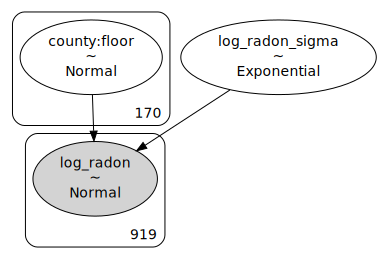

In [21]:
unpooled_model.graph()

From the graph representation of the model we see that the we are estimating $170 = 85 \times 2$ parameters from the `county:floor` interaction. Let us now compute the summary statistics of the model.

We can now see the posterior sample plot distributions:

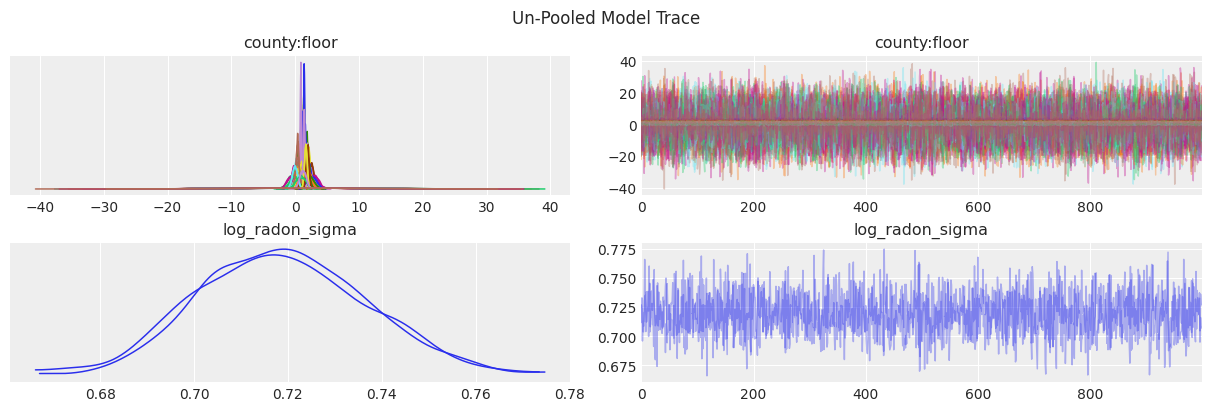

In [22]:
az.plot_trace(data=unpooled_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Un-Pooled Model Trace");

To obtain a better summary visualization we can use a forest plot:

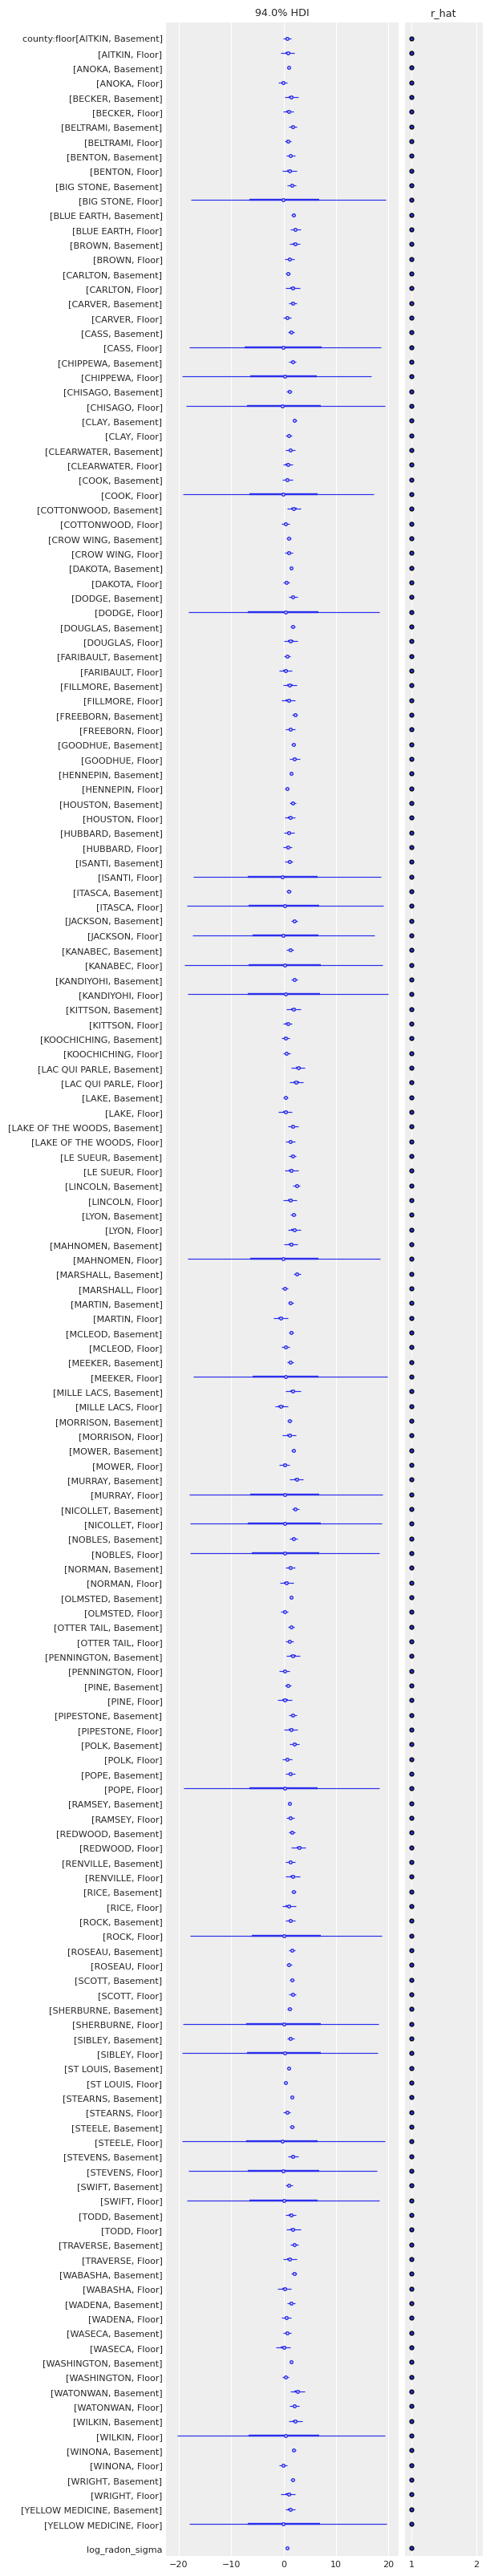

In [23]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

Note how for the combination `county == 'YELLOW MEDICINE' and floor == 'Floor'` where we do not have any observations, the model can still generate predictions which are essentially coming from the prior distributions, which explains the large hdi intervals.

Next let us look into the posterior mean for each `county` and `floor` combination:

In [24]:
unpooled_summary = az.summary(data=unpooled_results)

We can now plot the posterior distribution mean of the beta coefficients against the observed values (sample).

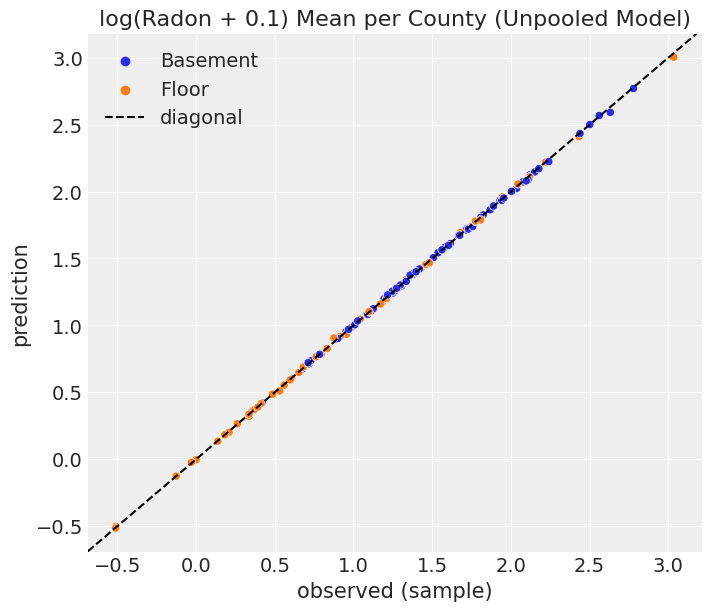

In [25]:
# Get county and floor names from summary table
var_mapping = (
    unpooled_summary
    .iloc[:-1]
    .reset_index(drop=False)["index"].str.slice(13, -1).str.split(",").apply(pd.Series)
)

var_mapping.rename(columns={0: "county", 1: "floor"}, inplace=True)
var_mapping["county"] = var_mapping["county"].str.strip()
var_mapping["floor"] = var_mapping["floor"].str.strip()
var_mapping.index = unpooled_summary.iloc[:-1].index
    
# Merge with observed values
unpooled_summary_2 = pd.concat([var_mapping, unpooled_summary.iloc[:-1]], axis=1)


fig, ax = plt.subplots(figsize=(7, 6))
(
    unpooled_summary_2
    .merge(right=log_radon_county_agg, on=["county", "floor"], how="left")
    .pipe(
        (sns.scatterplot, "data"),
        x="log_radon_mean",
        y="mean",
        hue="floor",
        ax=ax
    )
)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="log(Radon + 0.1) Mean per County (Unpooled Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
);

As expeced, the values strongly concentrated along the diagonal.

## Multilevel and Hierarchical Models

In this section we are going to explore various types of hierarchical models.If you're familiar with the PyMC way of using hierarchies, the Bambi way (borrowed from mixed effects models way) may be a bit confusing in the beginning, but as we will see, the notation is very convenient. A good explanation is found in Chapter 16 from Bayes Rules book, specifically section 16.3.2. Moreover, you can also take a look into the [Bambi examples section](https://bambinos.github.io/bambi/main/examples.html) where you can fin other use cases.

### Partial Pooling Model

We start with the *partial pooling model*, in which we estimate the radon level for each `county` (not considering `floor` for now) with the additional ingredient that we use a *hyper-prior* distribution over the intercept parameters.  Why _partial pooling_? We have the intercept, which represents the mean of the response variable across all the Counties. We also have the random deviations from that general mean. Those random devations are given by the County specific term $u_{j}$. These terms are the one to "blame" for the partial pooling, i.e., sharing information across County levels. This is a result of the hyperprior $\sigma_u$ which is the same for all Counties.

#### Model

Ley us use greek letters for common effects and roman letters for varying effects. In this case, $\alpha$ is a common intercept and $u$ is a group-specific intercept. 

$$
y_{i} = \alpha + u_{j[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\alpha &= \text{Intercept common to all measurements} \\
u_{j[i]} &= \text{Intercept specific to the County } j \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$


#### Priors

##### Common effects

The only common effect in this model is the intercept $\alpha$. We have

$$
\alpha \sim \text{Normal}(0, \sigma_\alpha)
$$

where $\sigma_\alpha$ is a positive constant that we set to 10.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to 1.

##### Group-specific effects
$$
\begin{array}{lr}
u_{0j} \sim \text{Normal}(0, \sigma_u) & \text{for all } j:1, \cdots, 85
\end{array}
$$

where the hyperprior is 

$$

\sigma_u \sim \text{Exponential}(\tau)

$$

and $\tau$ is a positive constant that we set to $1$.

#### Notes

* The common intercept $\alpha$ represents the mean response across all Counties and floor levels.
* There is one County specific intercept $u_{j[i]}$ for each County $j$. This is also known as a _varying_ intercept because it varies across counties.
* The notation $j[i]$ means that the County level $j$ depends on the measurement $i$ we're looking at. This is because each measurement $i$ is tied to one, and only one County. This is different than the situation in [this example](https://github.com/bambinos/unfinished-ideas/blob/main/varying_effects_priors.ipynb) where we have $i = 1, \cdots, 10$ measurements for $j = 1, \cdots, 18$ subjects. In that case it is valid to write $y_ij$ because any combination of $i$ and $j$ makes sense. In our case, we only write $y_i$ because the value of $j$ is implicit in the value of $i$.

To specify this model in Bambi we use the formula `log_radon ~ 1 + (1|county)`. The term `(1|county)` represents a varying effect, where we want each `county` to have a different intercept.

In [26]:
# We can add the hyper-priors inside the prior dictionary parameter of the model constructor
partial_pooling_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

partial_pooling_model = bmb.Model(
    formula="log_radon ~ 1 + (1|county)", 
    data=df, 
    priors=partial_pooling_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
    noncentered=False,
)

partial_pooling_model

Formula: log_radon ~ 1 + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [27]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


We can inspect the graphical representation of the model:

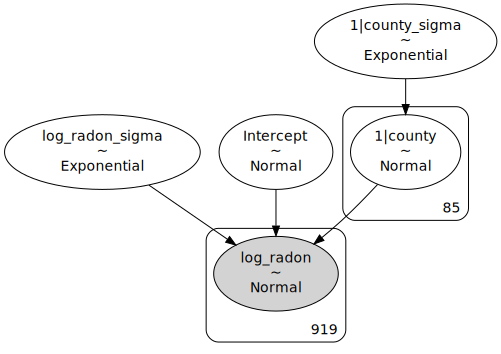

In [28]:
partial_pooling_model.graph()

We can clearly see a new hierarchical level as compared to the complete pooling model and unpooled model.

Next, we can plot the posterior distribution of the intercepts:

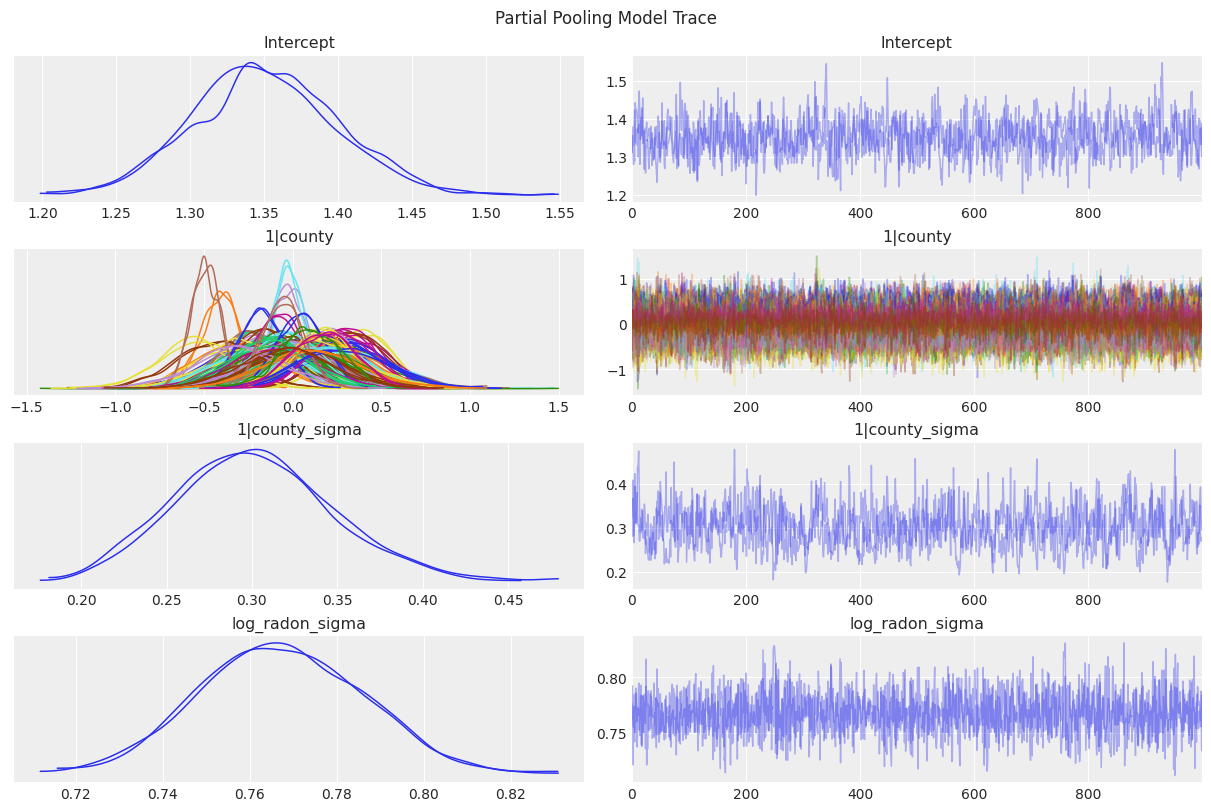

In [29]:
az.plot_trace(data=partial_pooling_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Partial Pooling Model Trace");

In [30]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

Let us now compare the posterior predictive mean against the observed data at county level.

In [ ]:
pps.shape

(2, 2000)

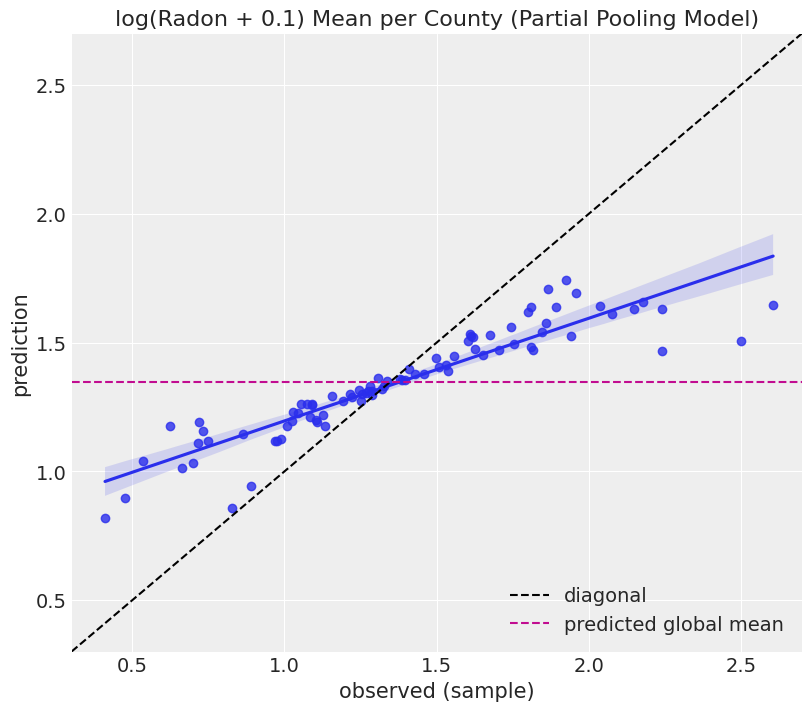

In [ ]:
partial_pooling_model.predict(partial_pooling_results, kind="pps")

# Stack chains and draws. pps stands for posterior predictive samples
pps = partial_pooling_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

pps_df = pd.DataFrame(data=pps).assign(county=df["county"])
y_pred = pps_df.groupby("county").mean().mean(axis=1)
y_sample = df.groupby("county")["log_radon"].mean()

fig, ax = plt.subplots(figsize=(8, 7))
sns.regplot(x=y_sample, y=y_pred, ax=ax)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.axhline(y=y_pred.mean(), color="C3", linestyle="--", label="predicted global mean")
ax.legend(loc="lower right")
ax.set(
    title="log(Radon + 0.1) Mean per County (Partial Pooling Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
    xlim=(0.3, 2.7),
    ylim=(0.3, 2.7),
);

Note that in this case the points are not concentrated along the diagonal (as it was the case for the unpooled model). The reason is that in the partial pooling model the hyperprior shrinks the predictions towards the global mean.

### Varying Intercept Model


Next, we add the `floor` global feature (i.e. does not depend on the `county`) into the model above. 

#### Model

$$
y_{i} = \beta_{j[i]} + u_{k[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the (log) Radon measurement } i \\
\beta_{j[i]} &= \text{Intercept for the Floor level } j \\
u_{k[i]} &= \text{Intercept specific to the County } k \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The only common effect in this model is the floor term $\beta_{j[i]}$

$$
\beta_{j[i]} \sim \text{Normal}(0, \sigma_\beta)
$$

where $\sigma_{\beta}$ is a positive constant that we set to $10$.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to $1$.

##### Group-specific effects
 
$$
\begin{array}{lr}
u_{0j} \sim \text{Normal}(0, \sigma_u) & \text{for all } j:1, \cdots, 85 
\end{array}
$$
(should $u_{0j}$ be $u_{k[i]}$  ???)

where the hyperprior is 

$$

\sigma_u \sim \text{Exponential}(\tau)

$$

and $\tau$ is a positive constant that we set to $1$.

**Notes** 


* $\beta_{j[i]}$ and $u_{k[i]}$ look similar. The difference is that the latter is a hierarchical effect (has a hyperprior), while the former is not.
* The previous model is also a varying intercept model (the term `(1 | county)` is also present)


In [ ]:
varying_intercept_priors = {
    "floor": bmb.Prior(name="Normal", mu=0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

varying_intercept_model = bmb.Model(
    formula="log_radon ~ 0 + floor + (1|county)",
    data=df,
    priors=varying_intercept_priors,
    link="identity",
    auto_scale=False,
    noncentered=False,
 )

varying_intercept_model

Formula: log_radon ~ 0 + floor + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [ ]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


When looking at the graph representation of the model we still see the hierarchical structure for the `county` varying intercepts, but we do not see it for the `floor` feature as expected.

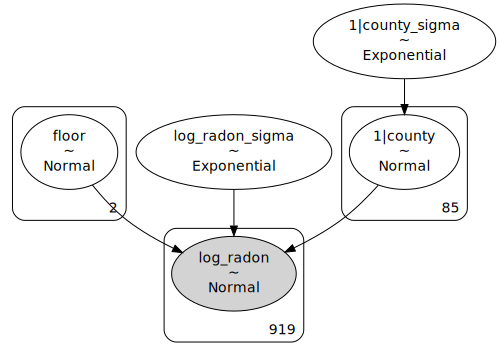

In [ ]:
varying_intercept_model.graph()

Let us visualize the posterior distributions:

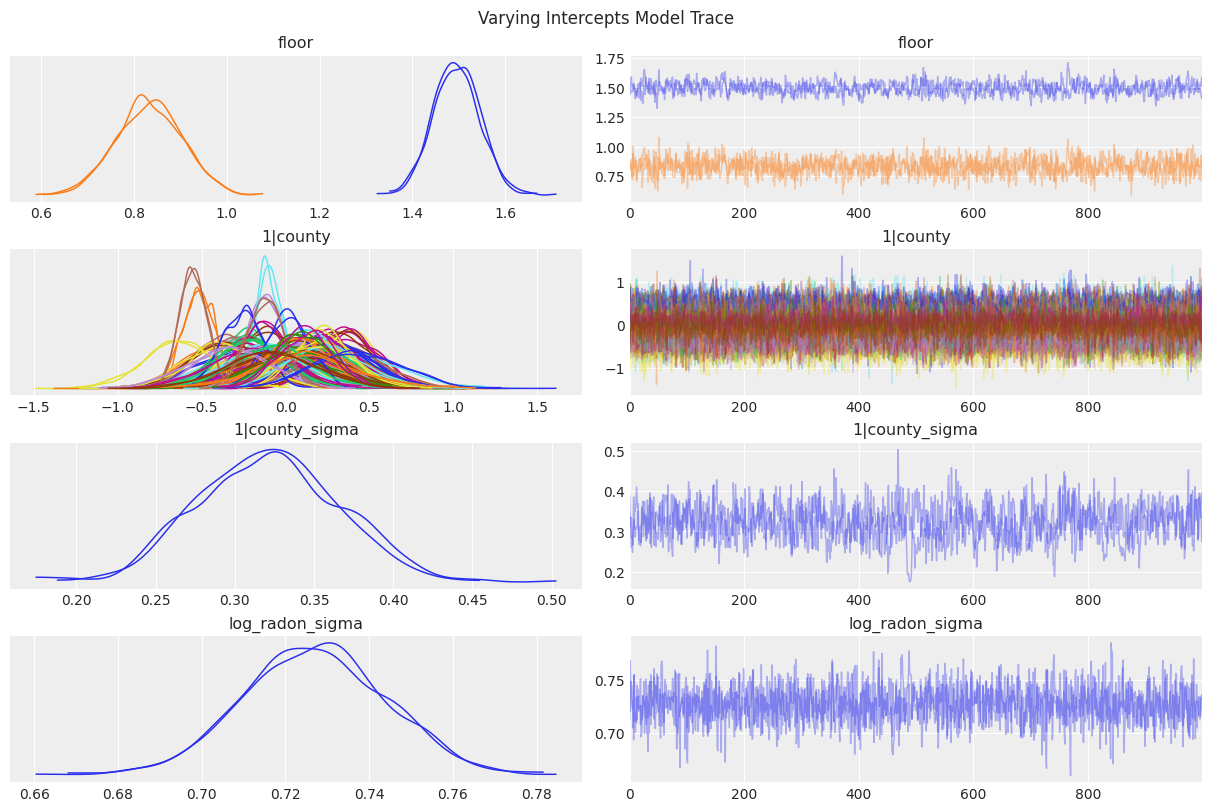

In [ ]:
az.plot_trace(data=varying_intercept_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Varying Intercepts Model Trace");

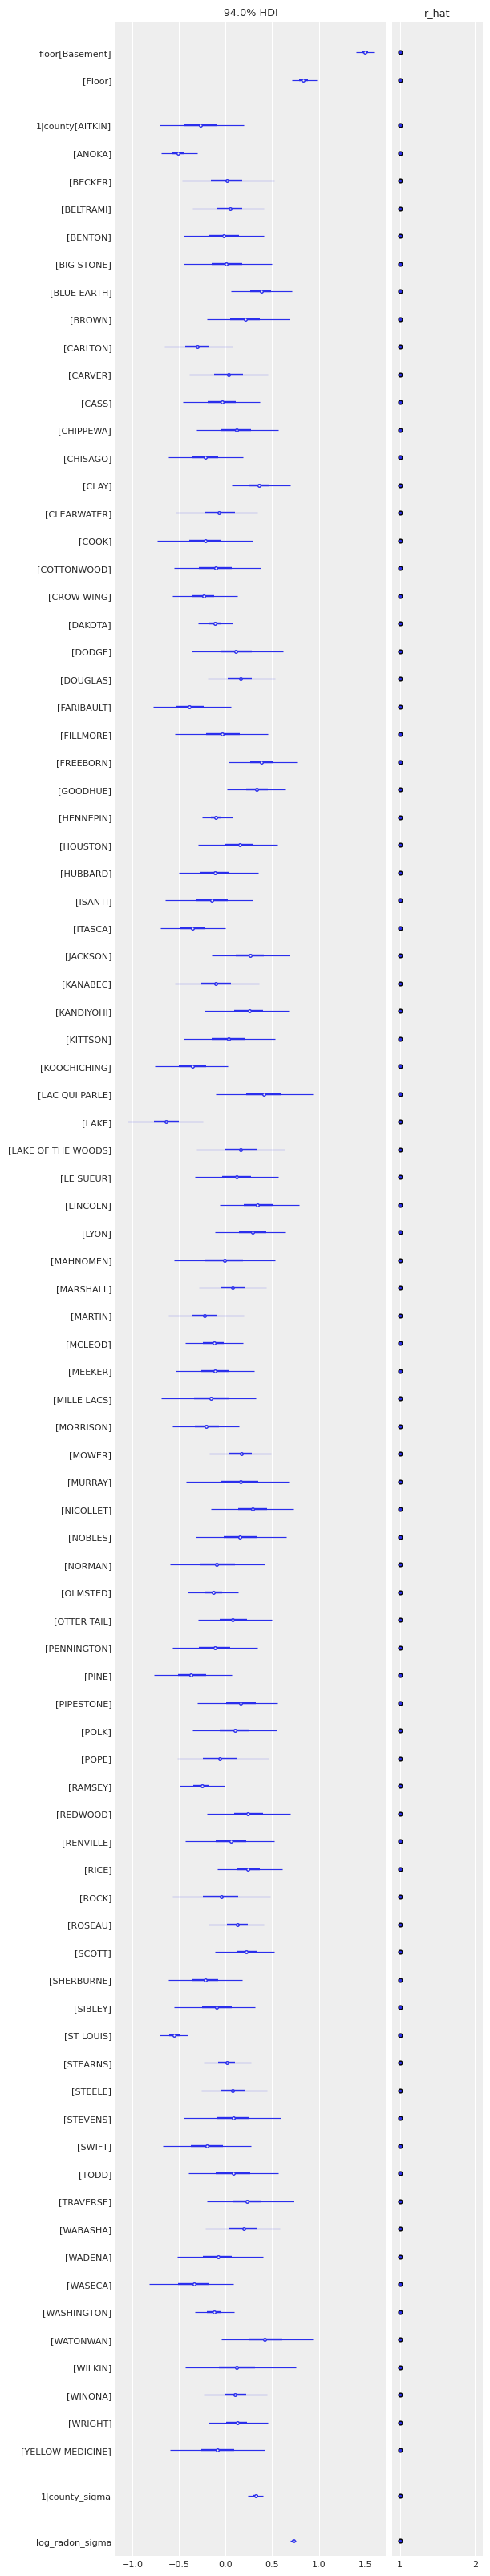

In [ ]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept and Slope Model

Next we want to include a hierarchical structure in the Floor effect.

#### Model

$$
y_{i} = \alpha + \beta_{j[i]}+ u_{k[i]} + \varepsilon_{i}
$$

where

$$
\begin{aligned}
y_{i} &= \text{Response for the Radon measurement } i \\
\alpha &= \text{Intercept common to all measurements} \\
\beta_{j[i]} &= \text{Intercept deviation for the Floor level } j \\
u_{k[i]} &= \text{Intercept deviation for the County } k \\
\varepsilon_{i} & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The only common effect in this model is the intercept $\alpha$

$$
\alpha \sim \text{Normal}(0, \sigma_\alpha)
$$

where $\sigma_\alpha$ is a positive constant that we set to $5$.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to 1.

##### Group-specific effects

We have two group-specific effects in this model. 

1. First the intercepts,

$$
\begin{array}{lr}
u_{k[i]} \sim \text{Normal}(0, \sigma_u) & \text{for all } j:1, \cdots, 85
\end{array}
$$

where the hyperprior is 

$$

\sigma_u \sim \text{Exponential}(\tau_{u})

$$

and $\tau_{u}$ is a positive constant that we set to $1$.

2. The floor effects 

$$
\begin{array}{lr}
\beta_{k[j]} \sim \text{Normal}(0, \sigma_\beta) & \text{for all } j:1, \cdots, 85
\end{array}
$$

where the hyperprior is 

$$

\sigma_\beta \sim \text{Exponential}(\tau_{\beta})

$$

and $\tau_{\beta}$ is a positive constant that we set to $0.5$.


**Notes** 

* Both $\beta_{j[i]}$ and $u_{k[i]}$ are hierarchical now, they both have a hyperprior.


In this case the Bambi model specification is quite easy, namely `log_radon ~ (floor|county)`. This formula actually represent the following terms:
 - `Intercept`, which encodes the common effect $\alpha$.
 - `1|county` represent the varying intercepts.
 - `floor|county` represents the varying slopes.
 - `sigma` is the standard deviation of the errors. 


In [ ]:
varying_intercept_slope_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "floor|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

# Another alternative for the formula, which is more explicit, is "log_radon ~ (1|county) + (floor|county)"
# Even more explicit is "log_radon ~ 1 + (1|county) + (floor|county)"
varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ (floor|county)",
    data=df,
    priors=varying_intercept_slope_priors,
    link="identity",
    auto_scale=False,
    noncentered=False,
 )

varying_intercept_slope_model

Formula: log_radon ~ (floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))
    floor|county ~ Normal(mu: 0, sigma: Exponential(lam: 0.5))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [ ]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor|county, floor|county_sigma, 1|county, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


In the graph representation of the model we can now see hierarchical structures both in the intercepts and the slopes.

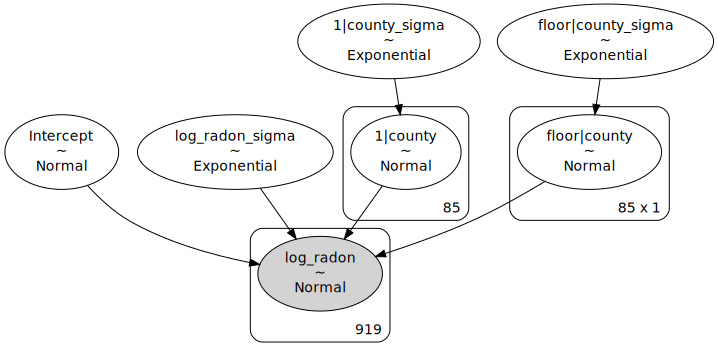

In [ ]:
varying_intercept_slope_model.graph()

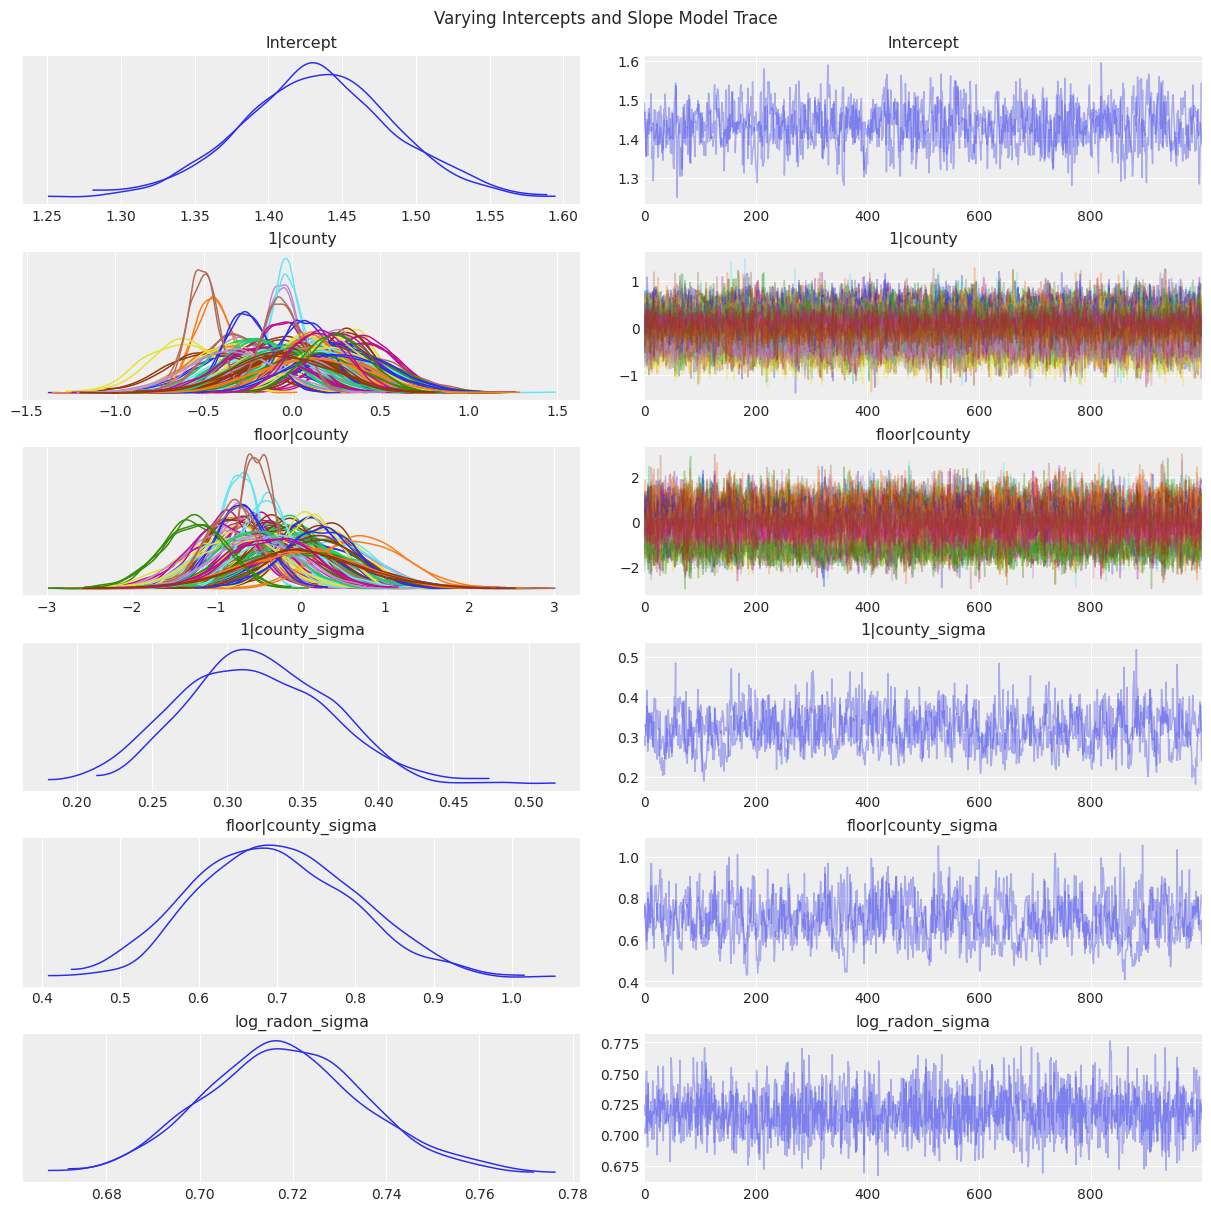

In [ ]:
az.plot_trace(data=varying_intercept_slope_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Varying Intercepts and Slope Model Trace");

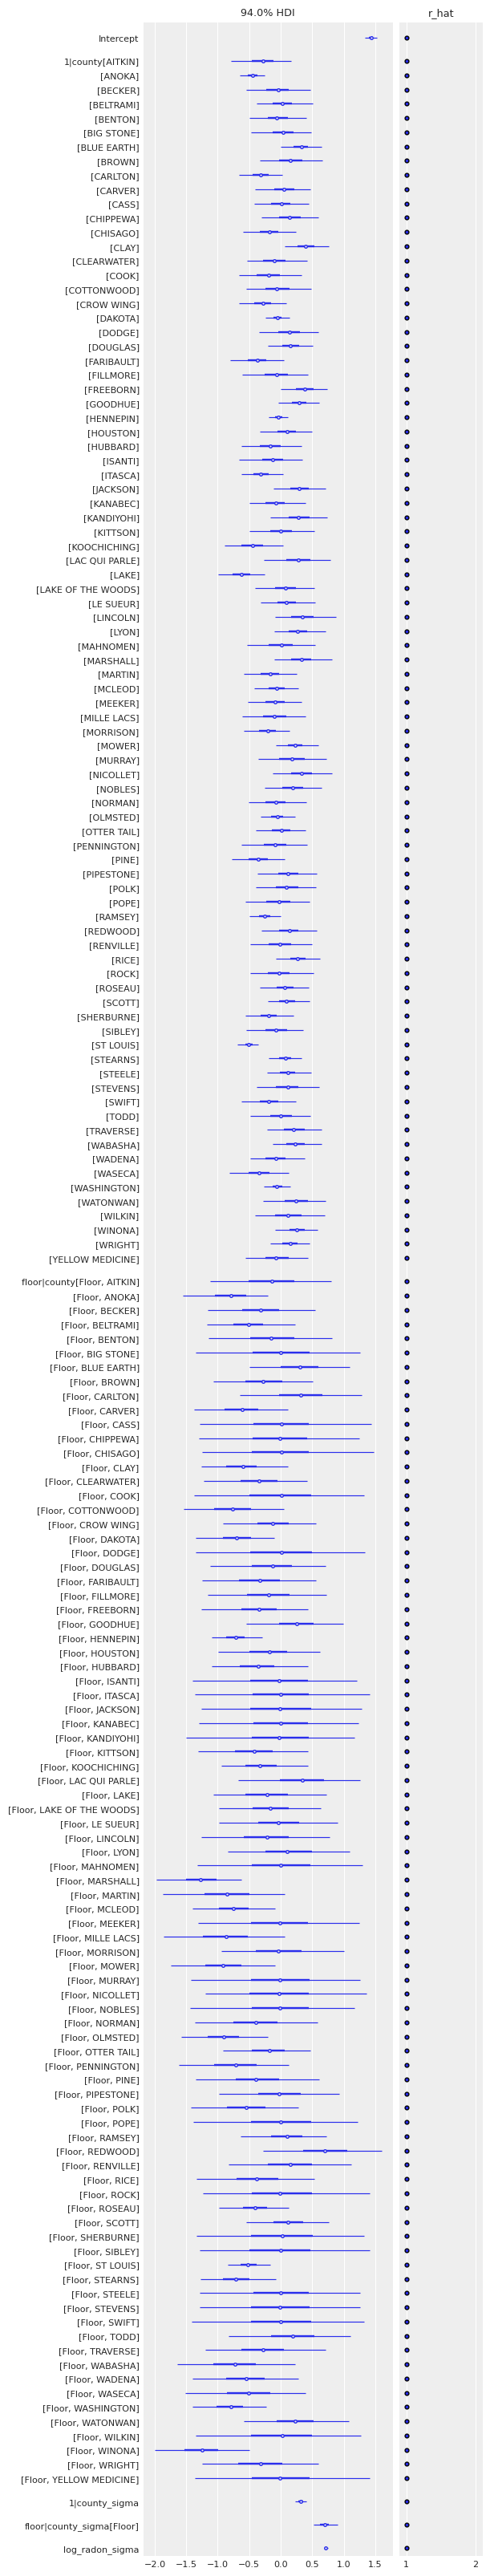

In [ ]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Adding group-level predictors

I don't know why the original post says "group level predictors" because this is not a predictor at the group level (as floor is, for example)

In [ ]:
covariate_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "log_u": bmb.Prior("Normal", mu=0, sigma=1),
    "floor": bmb.Prior("Normal", mu=0, sigma=1),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "floor|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

covariate_model = bmb.Model(
    formula="log_radon ~ 1 + floor + log_u + (1|county)",
    data=df,
    priors=covariate_priors
 )

covariate_model

Formula: log_radon ~ 1 + floor + log_u + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5)
    floor ~ Normal(mu: 0, sigma: 1)
    log_u ~ Normal(mu: 0, sigma: 1)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [ ]:
covariate_results = covariate_model.fit(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county_offset, 1|county_sigma, log_u, floor, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


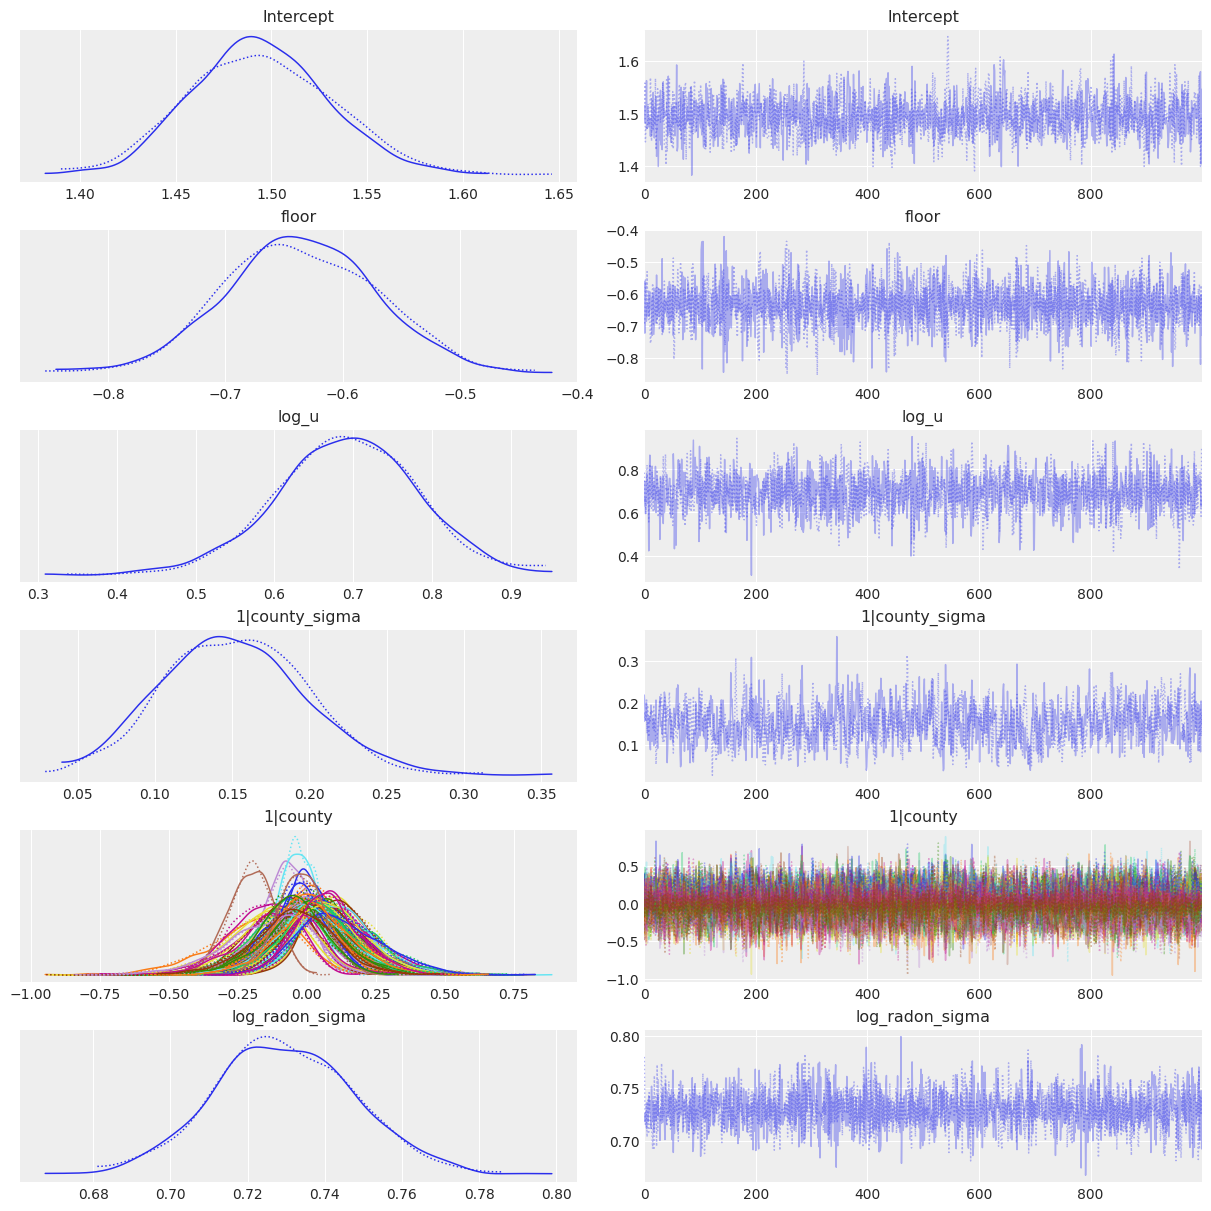

In [ ]:
az.plot_trace(covariate_results);

I got a bit lost here. I'm not sure whether we are fitting the same model, and how to create the chart that's in the original blog.

In [ ]:
y_sample = df.groupby(["county"])["log_u"].mean().values

In [ ]:
u_slope = covariate_results.posterior["log_u"].values[..., None] * y_sample

In [ ]:
intercepts = (covariate_results.posterior["Intercept"] + covariate_results.posterior["1|county"]).values
y = (intercepts + u_slope).reshape(2000, 85).T

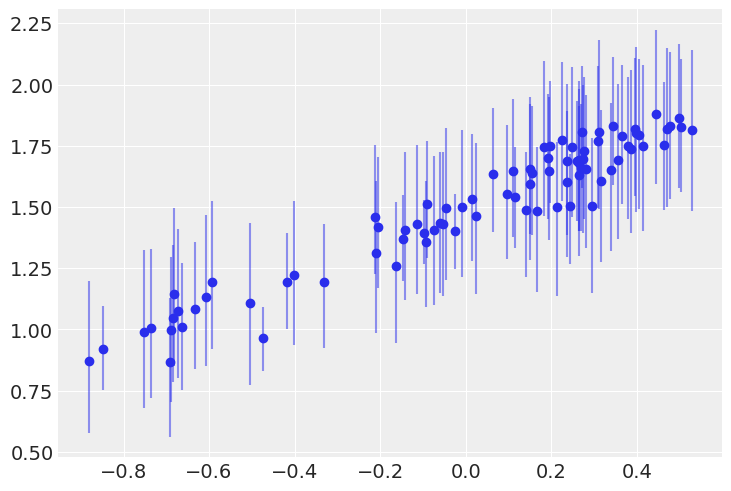

In [ ]:
fig, ax = plt.subplots()

qts = np.quantile(y, q=[0.03, 0.96], axis=1)
ax.scatter(y_sample, y.mean(1))
ax.vlines(y_sample, qts[0], qts[1], alpha=0.5);

---

**NOTE:** We can do the following and it "works". But I wouldn't keep this in this notebook because it is still quite experimental and buggy. I'd prefer to fix the implementation and we can update the notebook after that.

In [ ]:
priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "floor|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

cov_model = bmb.Model(
    formula="log_radon ~ (0 + floor|county)",
    data=df,
    priors=priors,
    priors_cor={"county": 2}
 )

cov_model.build()

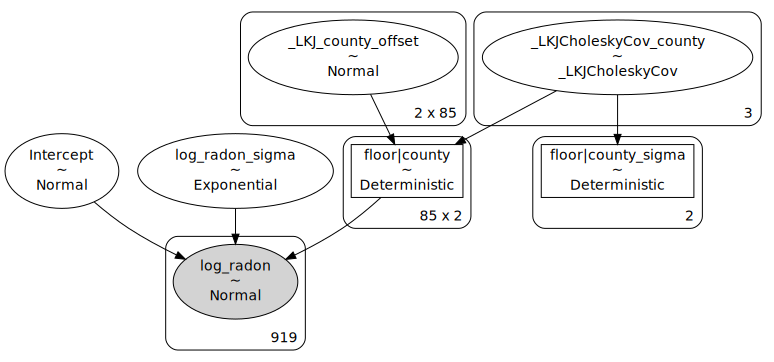

In [ ]:
cov_model.graph()

In [ ]:
cov_results = cov_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, _LKJ_county_offset, _LKJCholeskyCov_county, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


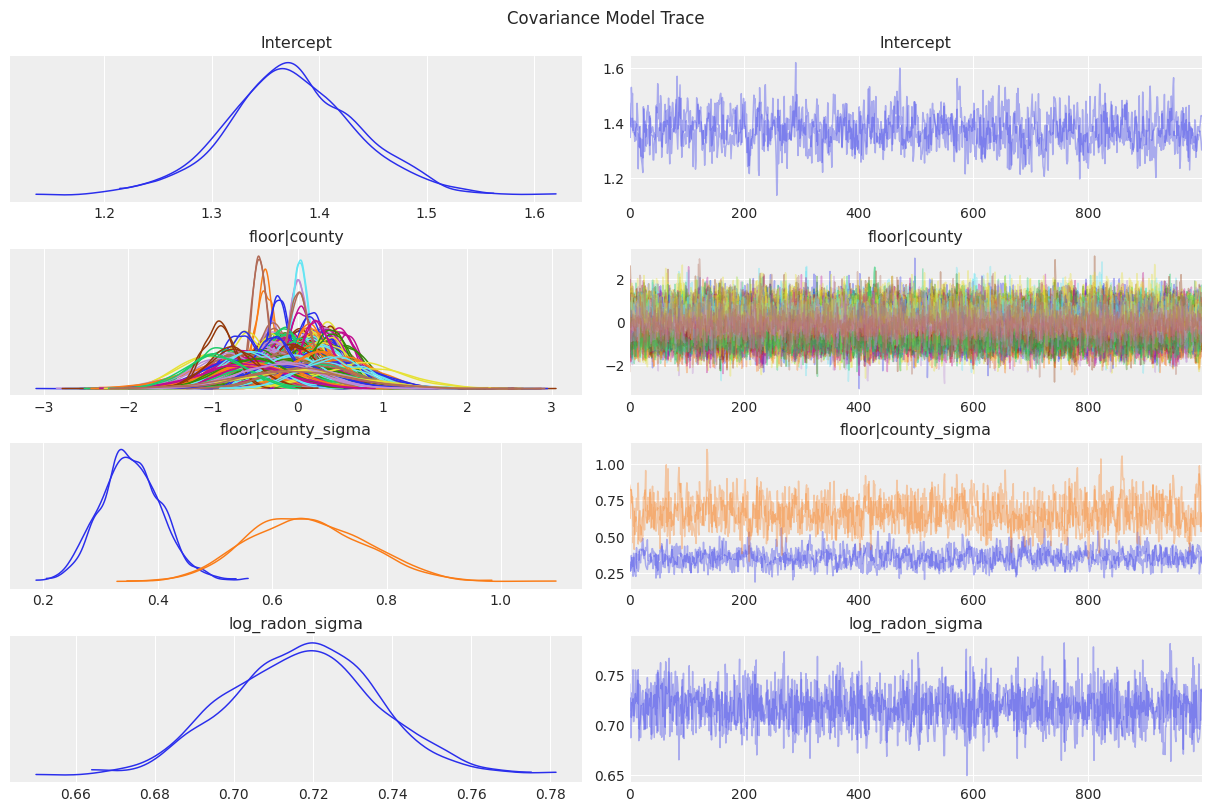

In [ ]:
az.plot_trace(data=cov_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Covariance Model Trace");

---

### Model Comparison

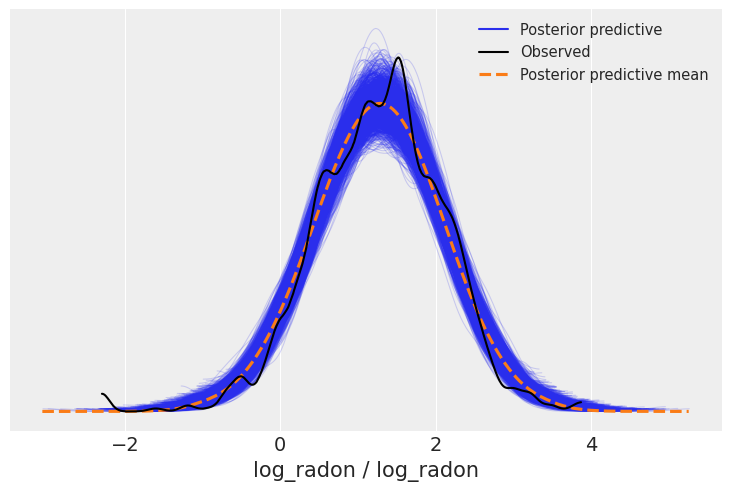

In [ ]:
pooled_model.predict(pooled_results, kind="pps")
az.plot_ppc(pooled_results);

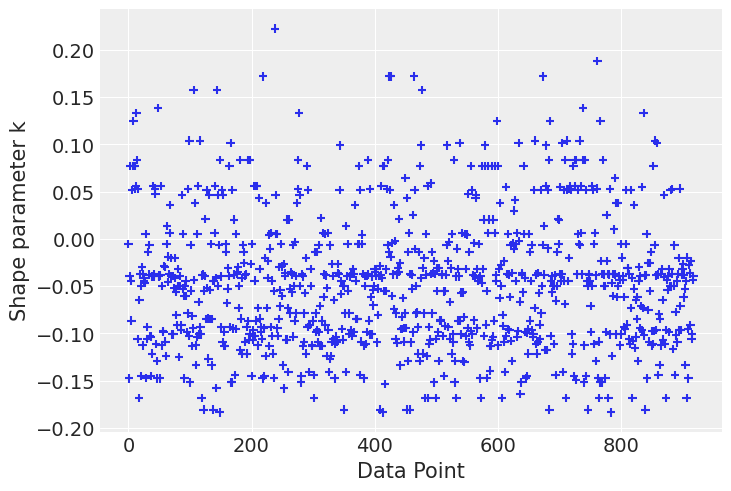

In [ ]:
loo = az.loo(pooled_results, pointwise=True)
az.plot_khat(loo.pareto_k);

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


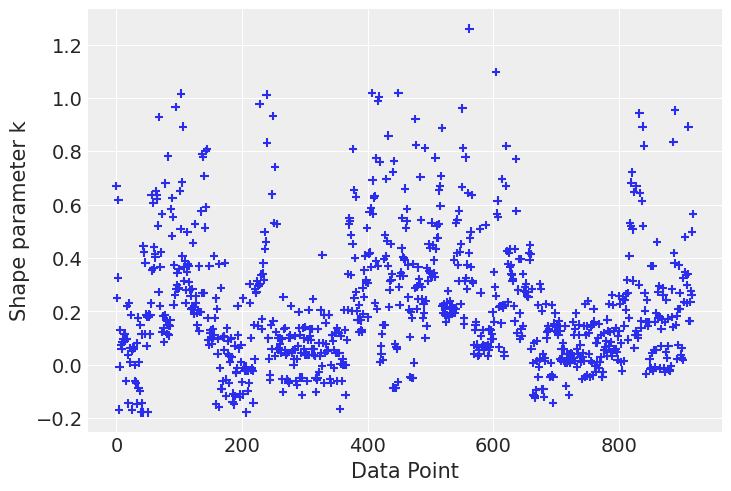

In [ ]:
loo = az.loo(unpooled_results, pointwise=True)
az.plot_khat(loo.pareto_k);

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


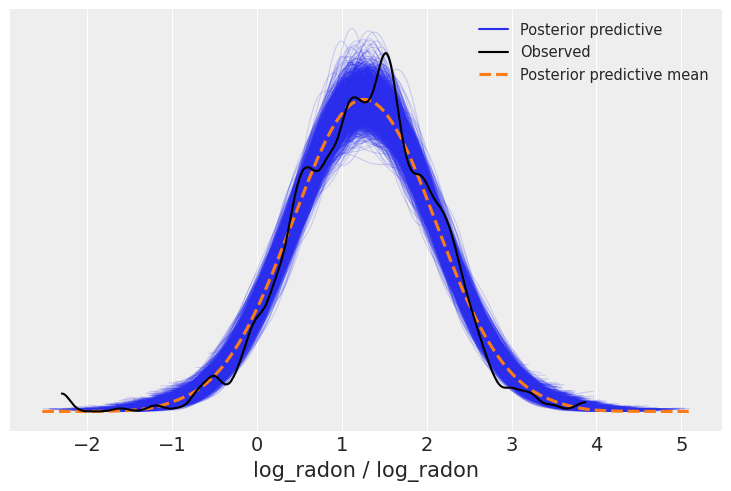

In [ ]:
partial_pooling_model.predict(partial_pooling_results, kind="pps")
az.plot_ppc(partial_pooling_results);

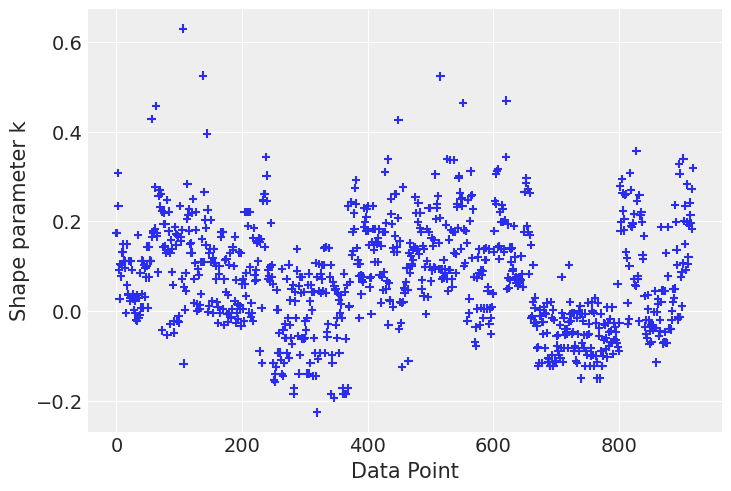

In [ ]:
loo = az.loo(partial_pooling_results, pointwise=True)
az.plot_khat(loo.pareto_k);

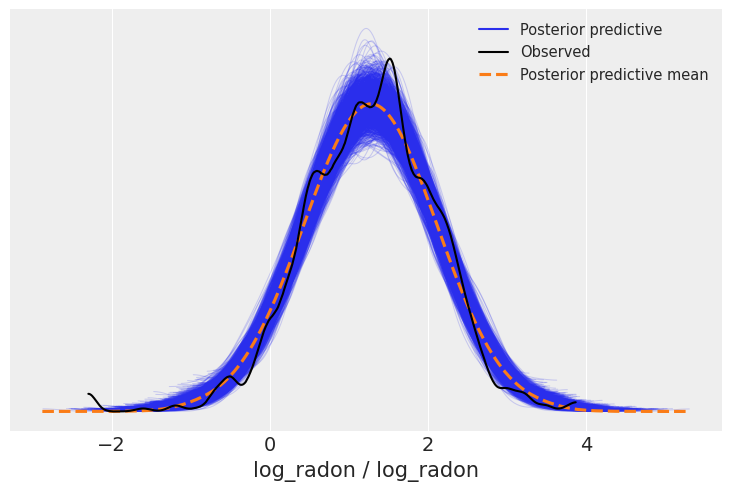

In [ ]:
varying_intercept_model.predict(varying_intercept_results, kind="pps")
az.plot_ppc(varying_intercept_results);

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


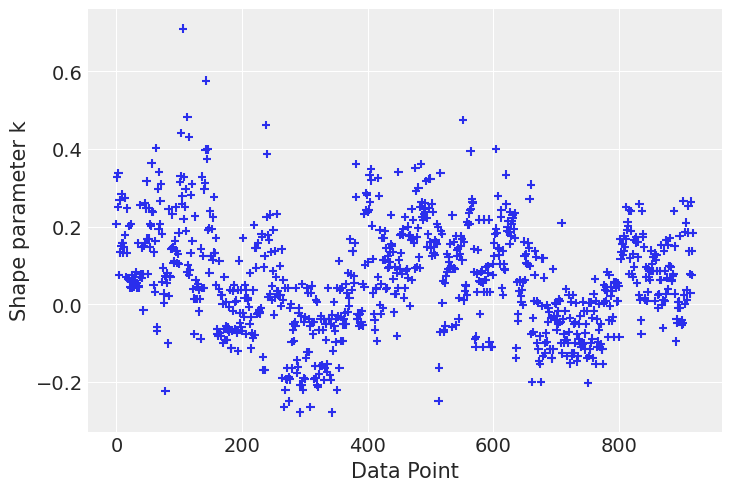

In [ ]:
loo = az.loo(varying_intercept_results, pointwise=True)
az.plot_khat(loo.pareto_k);

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


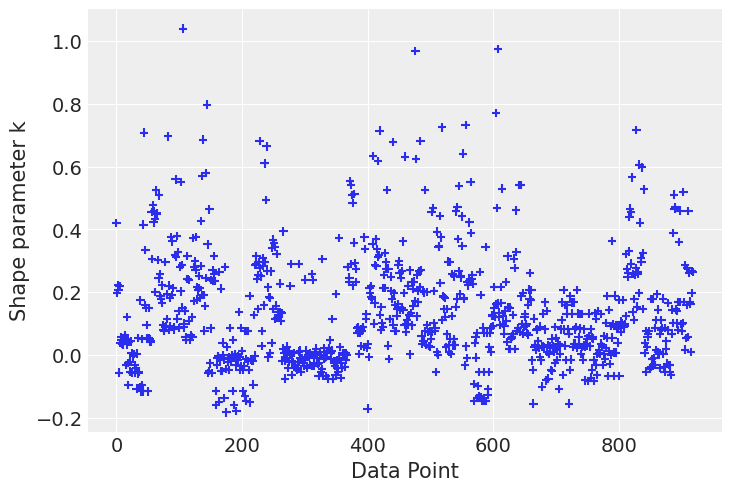

In [ ]:
loo = az.loo(varying_intercept_slope_results, pointwise=True)
az.plot_khat(loo.pareto_k);

In [ ]:
dataset_dict = {
    "pooled": pooled_results,
    "unpooled": unpooled_results,
    "partial_pooling": partial_pooling_results,
    "varying_intercept": varying_intercept_results,
    "varying_intercept_slope": varying_intercept_slope_results,
    "cov": cov_results,
}

az.compare(dataset_dict=dataset_dict)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-

rank          loo       p_loo      d_loo    weight  \
varying_intercept           0 -1036.938037   49.359294   0.000000  0.694813   
cov                         1 -1051.136645   89.488687  14.198608  0.108288   
varying_intercept_slope     2 -1052.228397   88.927689  15.290360  0.057473   
partial_pooling             3 -1083.755305   44.299900  46.817269  0.034117   
pooled                      4 -1090.050311    3.917243  53.112274  0.073623   
unpooled                    5 -1095.037860  146.605708  58.099823  0.031686   

                                se        dse  warning loo_scale  
varying_intercept        27.985975   0.000000     True       log  
cov                      29.995615   7.516121     True       log  
varying_intercept_slope  30.389688   7.678865     True       log  
partial_pooling          28.761244  10.803484    False       log  
pooled                   25.051938  10.766746    False       log  
unpooled                 29.766342  12.413813     True       log